In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from huggingface_hub import PyTorchModelHubMixin
from PIL import Image
import os
import numpy as np
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from huggingface_hub import PyTorchModelHubMixin
from torchvision import transforms



import pickle
import torch.optim as optim
from geopy.distance import geodesic
from torch.optim.lr_scheduler import StepLR


# 1. Load Data


In [ ]:
# mount colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#get the current directory
import os
os.getcwd()

'/content'

In [ ]:
path = f"/content/drive/MyDrive/CIS519Project"
os.listdir(path)

['images',
 'img_edited',
 'img_data.csv',
 'img_data.pkl',
 'densenet_1.pkl',
 'densenet_161.pkl',
 'densenet_201.pkl',
 'output',
 'Download.ipynb',
 'img_0502',
 'untitle.ipynb',
 'img_resize',
 'img_data_new_version.csv',
 'data_process.ipynb',
 'img_data_new_version.pkl',
 'EfficientNet_B1.pkl',
 'densenet_201_0502.pkl',
 'EfficientNet_B0.pkl',
 'EfficientNet_B3.pkl',
 'Ensemble1.ipynb',
 'Weighted_Model_Ensemble.ipynb',
 'densenet_test.ipynb',
 'model.ipynb']

In [ ]:
# load the csv file 'img_data.csv'
csv_file = pd.read_csv(f"{path}/img_data_new_version.csv")

In [ ]:
image_path = os.path.join(path, "img_edited")
image_path

'/content/drive/MyDrive/CIS519Project/img_edited'

In [ ]:
len(csv_file)

3318

In [ ]:
# rows = []
# for _, r in csv_file.iterrows():

#     img_path  = os.path.join(image_path, r["file_name"])
#     image     = Image.open(img_path)

#     rows.append(pd.DataFrame(
#         {"image":      [image],
#          "latitude":   [r["Latitude"]],
#          "longitude":  [r["Longitude"]]}
#     ))

#     if len(rows) % 200 == 0:
#         print(f"Currently read {len(rows)} images")

# df = pd.concat(rows, ignore_index=True)


KeyboardInterrupt: 

In [ ]:
# # save df file to pickle
# df.to_pickle(f"{path}/img_data_new_version.pkl")

In [ ]:
# load img_data.pkl
df = pd.read_pickle(f"{path}/img_data_new_version.pkl")

In [ ]:
len(df)

3318

In [ ]:
df.head()

,image,latitude,longitude
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39.951294,-75.191672
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39.951297,-75.191658
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39.951278,-75.191664
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39.951275,-75.191664
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39.951275,-75.191664


# 2. Transform data and create dataset

In [ ]:
class GPSImageDataset(Dataset):
    def __init__(self, dataset, transform=None, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.dataset = dataset
        self.transform = transform

        # Compute mean and std from the dataframe if not provided
        self.latitude_mean = lat_mean if lat_mean is not None else np.mean(np.array(self.dataset['latitude']))
        self.latitude_std = lat_std if lat_std is not None else np.std(np.array(self.dataset['latitude']))
        self.longitude_mean = lon_mean if lon_mean is not None else np.mean(np.array(self.dataset['longitude']))
        self.longitude_std = lon_std if lon_std is not None else np.std(np.array(self.dataset['longitude']))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Extract data
        example = self.dataset.iloc[idx]

        # Load and process the image
        image = example['image']
        latitude = example['latitude']
        longitude = example['longitude']
        # image = image.rotate(-90, expand=True)
        if self.transform:
            image = self.transform(image)

        # Normalize GPS coordinates
        latitude = (latitude - self.latitude_mean) / self.latitude_std
        longitude = (longitude - self.longitude_mean) / self.longitude_std
        gps_coords = torch.tensor([latitude, longitude], dtype=torch.float32)

        return image, gps_coords

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),  # Random rotation between -15 and 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
train_dataset = GPSImageDataset(dataset=train_df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Create the validation dataset and dataloader using training mean and std
val_dataset = GPSImageDataset(
    dataset=test_df,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 3. EfficientNet_B3

In [ ]:
class CustomEfficientNetB0(nn.Module, PyTorchModelHubMixin):
    """
    EfficientNet‑B0 for 2‑D regression (lat, lon).
    Works with:
      • google/efficientnet-b0
      • timm/efficientnet_b0.ra_in1k        (old & new Transformers)
      • any other EfficientNet‑B0 checkpoint
    """

    def __init__(self,
                 model_name: str = "timm/efficientnet_b0.ra_in1k",
                 num_outputs: int = 2):
        super().__init__()

        self.backbone = AutoModelForImageClassification.from_pretrained(model_name)

        if hasattr(self.backbone, "classifier"):
            clf = self.backbone.classifier

        elif hasattr(self.backbone, "model") and hasattr(self.backbone.model, "classifier"):
            clf = self.backbone.model.classifier
            parent = self.backbone.model

        elif hasattr(self.backbone, "timm_model") and hasattr(self.backbone.timm_model, "classifier"):
            clf = self.backbone.timm_model.classifier
            parent = self.backbone.timm_model

        elif hasattr(self.backbone, "model") and hasattr(self.backbone.model, "fc"):
            clf = self.backbone.model.fc
            parent = self.backbone.model
        else:
            raise AttributeError("Could not locate classifier head in the loaded checkpoint.")

        in_features = clf.in_features


        new_head = nn.Linear(in_features, num_outputs)

        if hasattr(self.backbone, "classifier"):
            self.backbone.classifier = new_head
        else:
            parent.classifier = new_head

    # plain forward
    def forward(self, pixel_values, **kwargs):
        return self.backbone(pixel_values, **kwargs).logits  # returns (N, 2)

    # convenience wrappers (unchanged)
    def save_model(self, path: str):
        self.save_pretrained(path)

    def push_model(self, repo_name: str):
        self.push_to_hub(repo_name)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
model = CustomEfficientNetB0(
    model_name="google/efficientnet-b3",
    num_outputs=2
).to(device)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with validation
num_epochs = 15
EfficientNet_B3_val_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, gps_coords in train_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, gps_coords)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    baseline_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, gps_coords in val_dataloader:
            images = images.to(device)
            gps_coords = gps_coords.to(device)

            batch_size = gps_coords.size(0)
            total_samples += batch_size

            # Model predictions
            outputs = model(images)

            # Denormalize predictions and actual GPS coordinates
            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = gps_coords.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            # Compute geodesic distances between predictions and actuals
            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                val_loss += distance ** 2  # Squared distance

            # Baseline predictions
            baseline_preds = np.array([lat_mean, lon_mean])

            # Compute geodesic distances between baseline preds and actuals
            for actual in actuals_denorm:
                distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
                baseline_loss += distance ** 2  # Squared distance

    # Compute average losses
    val_loss /= total_samples
    baseline_loss /= total_samples

    # Compute RMSE
    val_rmse = np.sqrt(val_loss)
    baseline_rmse = np.sqrt(baseline_loss)
    EfficientNet_B3_val_loss.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

print('Training complete')

Epoch [1/15], Training Loss: 0.5466
Epoch [1/15], Validation Loss (meters^2): 2740.45, Baseline Loss (meters^2): 10034.51
Epoch [1/15], Validation RMSE (meters): 52.35, Baseline RMSE (meters): 100.17
Epoch [2/15], Training Loss: 0.3031
Epoch [2/15], Validation Loss (meters^2): 2108.89, Baseline Loss (meters^2): 10034.51
Epoch [2/15], Validation RMSE (meters): 45.92, Baseline RMSE (meters): 100.17
Epoch [3/15], Training Loss: 0.2366
Epoch [3/15], Validation Loss (meters^2): 2306.85, Baseline Loss (meters^2): 10034.51
Epoch [3/15], Validation RMSE (meters): 48.03, Baseline RMSE (meters): 100.17
Epoch [4/15], Training Loss: 0.2341
Epoch [4/15], Validation Loss (meters^2): 1220.01, Baseline Loss (meters^2): 10034.51
Epoch [4/15], Validation RMSE (meters): 34.93, Baseline RMSE (meters): 100.17
Epoch [5/15], Training Loss: 0.2164
Epoch [5/15], Validation Loss (meters^2): 1265.55, Baseline Loss (meters^2): 10034.51
Epoch [5/15], Validation RMSE (meters): 35.57, Baseline RMSE (meters): 100.17


In [ ]:
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []
distances = []
model.eval()
# set the threshold to be 20 meters, we can test the accuracy by check if the output is less than the threshold or more than
threshold = 25
success = 0
total = 0
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = model(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for pred, actual in zip(preds, actuals):
          distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
          if distance < threshold:
            success += 1
          total += 1
          distances.append(distance)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
mse  = mean_squared_error(all_actuals, all_preds)  # plain MSE
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

avg_distance = sum(distances) / len(distances)
print(f"Avg Distance: {avg_distance}")
accuracy = 100 * success / total
print(f"Accuracy: {accuracy}")

Mean Absolute Error: 0.00011556962816017125
Root Mean Squared Error: 0.0001720199271593771
Avg Distance: 17.58387973632125
Accuracy: 80.87349397590361


In [ ]:
# save the model


# 4. DenseNet_201

In [ ]:
densenet = models.densenet201(pretrained=True)
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 2)

for param in densenet.parameters():
    param.requires_grad = True

# ========== Optimizer / Loss / Scheduler ==========

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# ========== Device ==========

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
densenet = densenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [ ]:
num_epochs = 20
DenseNet_201_val_loss = []
for epoch in range(num_epochs):
    # --- Training ---
    densenet.train()
    running_loss = 0.0
    for images, gps_coords in train_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        optimizer.zero_grad()
        outputs = densenet(images)             # (B, 2)
        loss = criterion(outputs, gps_coords)  # MSE on normalized coords
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} — Training Loss: {train_loss:.4f}")

    # --- Validation ---
    densenet.eval()
    val_loss = 0.0
    baseline_loss = 0.0
    total = 0

    with torch.no_grad():
        for images, gps_coords in val_dataloader:
            images, gps_coords = images.to(device), gps_coords.to(device)
            batch_size = gps_coords.size(0)
            total += batch_size

            preds = densenet(images).cpu().numpy()
            actuals = gps_coords.cpu().numpy()

            # Denormalize
            preds_denorm   = preds   * np.array([lon_std, lat_std]) + np.array([lon_mean, lat_mean])
            actuals_denorm = actuals * np.array([lon_std, lat_std]) + np.array([lon_mean, lat_mean])

            # Sum squared geodesic distances
            for p, a in zip(preds_denorm, actuals_denorm):
                d = geodesic((a[0], a[1]), (p[0], p[1])).meters
                val_loss += d**2

            # Baseline = predict mean coords every time
            for a in actuals_denorm:
                d0 = geodesic((a[0], a[1]), (lat_mean, lon_mean)).meters
                baseline_loss += d0**2

    val_loss     /= total
    baseline_loss/= total
    val_rmse      = np.sqrt(val_loss)
    base_rmse     = np.sqrt(baseline_loss)
    DenseNet_201_val_loss.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — Val Loss (m^2): {val_loss:.2f}, Base Loss (m^2): {baseline_loss:.2f}")
    print(f"                 Val RMSE (m): {val_rmse:.2f}, Baseline RMSE (m): {base_rmse:.2f}")

print("Training complete")

Epoch 1/20 — Training Loss: 0.7851
Epoch 1/20 — Val Loss (m^2): 4699.43, Base Loss (m^2): 223918994161887.47
                 Val RMSE (m): 68.55, Baseline RMSE (m): 14963923.09
Epoch 2/20 — Training Loss: 0.5757
Epoch 2/20 — Val Loss (m^2): 3281.84, Base Loss (m^2): 223918994161887.47
                 Val RMSE (m): 57.29, Baseline RMSE (m): 14963923.09
Epoch 3/20 — Training Loss: 0.4918
Epoch 3/20 — Val Loss (m^2): 3590.24, Base Loss (m^2): 223918994161887.47
                 Val RMSE (m): 59.92, Baseline RMSE (m): 14963923.09
Epoch 4/20 — Training Loss: 0.4470
Epoch 4/20 — Val Loss (m^2): 2363.13, Base Loss (m^2): 223918994161887.47
                 Val RMSE (m): 48.61, Baseline RMSE (m): 14963923.09
Epoch 5/20 — Training Loss: 0.3766
Epoch 5/20 — Val Loss (m^2): 1839.35, Base Loss (m^2): 223918994161887.47
                 Val RMSE (m): 42.89, Baseline RMSE (m): 14963923.09
Epoch 6/20 — Training Loss: 0.2898
Epoch 6/20 — Val Loss (m^2): 1187.74, Base Loss (m^2): 223918994161887.47
 

In [ ]:
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []
distances = []
densenet.eval()
# set the threshold to be 20 meters, we can test the accuracy by check if the output is less than the threshold or more than
threshold = 25
success = 0
total = 0
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = densenet(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for pred, actual in zip(preds, actuals):
          distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
          if distance < threshold:
            success += 1
          total += 1
          distances.append(distance)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
mse  = mean_squared_error(all_actuals, all_preds)  # plain MSE
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

avg_distance = sum(distances) / len(distances)
print(f"Avg Distance: {avg_distance}")
accuracy = 100 * success / total
print(f"Accuracy: {accuracy}")

Mean Absolute Error: 0.00015543587554928866
Root Mean Squared Error: 0.00022589305438196395
Avg Distance: 24.288101385307424
Accuracy: 64.60843373493977


# 5. ResNet50

In [ ]:
class CustomResNetModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, model_name="microsoft/resnet-18", num_classes=2):
        super().__init__()

        # Load pre-trained ResNet model from Hugging Face
        self.resnet = AutoModelForImageClassification.from_pretrained(model_name)

        # Access the Linear layer within the Sequential classifier
        in_features = self.resnet.classifier[1].in_features  # Accessing the Linear layer within the Sequential

        # Modify the classifier layer to have the desired number of output classes
        self.resnet.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

    def save_model(self, save_path):
        """Save model locally using the Hugging Face format."""
        self.save_pretrained(save_path)

    def push_model(self, repo_name):
        """Push the model to the Hugging Face Hub."""
        self.push_to_hub(repo_name)

In [ ]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # pretrained
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)



for p in resnet.parameters():
    p.requires_grad = True

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

resnet = resnet.to(device)

# Training loop with validation
num_epochs = 15
ResNet_50_val_loss = []
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, gps_coords in train_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, gps_coords)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet.eval()
    val_loss = 0.0
    baseline_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, gps_coords in val_dataloader:
            images = images.to(device)
            gps_coords = gps_coords.to(device)

            batch_size = gps_coords.size(0)
            total_samples += batch_size

            # Model predictions
            outputs = resnet(images)

            # Denormalize predictions and actual GPS coordinates
            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = gps_coords.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            # Compute geodesic distances between predictions and actuals
            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                val_loss += distance ** 2  # Squared distance

            # Baseline predictions
            baseline_preds = np.array([lat_mean, lon_mean])

            # Compute geodesic distances between baseline preds and actuals
            for actual in actuals_denorm:
                distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
                baseline_loss += distance ** 2  # Squared distance

    # Compute average losses
    val_loss /= total_samples
    baseline_loss /= total_samples

    # Compute RMSE
    val_rmse = np.sqrt(val_loss)
    baseline_rmse = np.sqrt(baseline_loss)
    ResNet_50_val_loss.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

print('Training complete')


Epoch [1/15], Training Loss: 0.6539
Epoch [1/15], Validation Loss (meters^2): 4956.76, Baseline Loss (meters^2): 10034.51
Epoch [1/15], Validation RMSE (meters): 70.40, Baseline RMSE (meters): 100.17
Epoch [2/15], Training Loss: 0.4767
Epoch [2/15], Validation Loss (meters^2): 4028.90, Baseline Loss (meters^2): 10034.51
Epoch [2/15], Validation RMSE (meters): 63.47, Baseline RMSE (meters): 100.17
Epoch [3/15], Training Loss: 0.3916
Epoch [3/15], Validation Loss (meters^2): 3196.12, Baseline Loss (meters^2): 10034.51
Epoch [3/15], Validation RMSE (meters): 56.53, Baseline RMSE (meters): 100.17
Epoch [4/15], Training Loss: 0.3187
Epoch [4/15], Validation Loss (meters^2): 1998.76, Baseline Loss (meters^2): 10034.51
Epoch [4/15], Validation RMSE (meters): 44.71, Baseline RMSE (meters): 100.17
Epoch [5/15], Training Loss: 0.2808
Epoch [5/15], Validation Loss (meters^2): 2385.72, Baseline Loss (meters^2): 10034.51
Epoch [5/15], Validation RMSE (meters): 48.84, Baseline RMSE (meters): 100.17


In [ ]:
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []
distances = []
resnet.eval()
# set the threshold to be 20 meters, we can test the accuracy by check if the output is less than the threshold or more than
threshold = 25
success = 0
total = 0
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs = resnet(images)

        # Denormalize predictions and actual values
        preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for pred, actual in zip(preds, actuals):
          distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
          if distance < threshold:
            success += 1
          total += 1
          distances.append(distance)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
mse  = mean_squared_error(all_actuals, all_preds)  # plain MSE
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

avg_distance = sum(distances) / len(distances)
print(f"Avg Distance: {avg_distance}")
accuracy = 100 * success / total
print(f"Accuracy: {accuracy}")

Mean Absolute Error: 0.0001433451090235207
Root Mean Squared Error: 0.00020443263193407345
Avg Distance: 22.26993200336105
Accuracy: 70.78313253012048


# 6. Model Ensemble

In [ ]:
# Set the weights for three model based on the val loss
EfficientNet_B3_final_loss = EfficientNet_B3_val_loss[-1]
DenseNet_201_final_loss  = DenseNet_201_val_loss[-1]
ResNet_50_final_loss     = ResNet_50_val_loss[-1]
losses = [EfficientNet_B3_final_loss, DenseNet_201_final_loss, ResNet_50_final_loss]
weights = [1/loss for loss in losses]
weights = [w/sum(weights) for w in weights]
weights

[0.33211738946439906, 0.3661208299374012, 0.3017617805981996]

In [ ]:
# evaluation based on the weights output
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize lists to store predictions and actual values
all_preds = []
all_actuals = []
distances = []
model.eval()
densenet.eval()
resnet.eval()

# set the threshold to be 25 meters, we can test the accuracy by check if the output is less than the threshold or more than
threshold = 25
success = 0
total = 0
with torch.no_grad():
    for images, gps_coords in val_dataloader:
        images, gps_coords = images.to(device), gps_coords.to(device)

        outputs_efficientNet = model(images)
        outputs_densenet = densenet(images)
        outputs_resnet = resnet(images)

        # preds = outputs.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        # Denormalize predictions and actual values
        preds_efficientNET = outputs_efficientNet.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        preds_densenet = outputs_densenet.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        preds_resnet = outputs_resnet.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        preds = (preds_efficientNET * weights[0] + preds_densenet * weights[1] + preds_resnet * weights[2])

        actuals = gps_coords.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds)
        all_actuals.append(actuals)

        for pred, actual in zip(preds, actuals):
          distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
          if distance < threshold:
            success += 1
          total += 1
          distances.append(distance)

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_actuals = torch.cat(all_actuals).numpy()

# Compute error metrics
mae = mean_absolute_error(all_actuals, all_preds)
mse  = mean_squared_error(all_actuals, all_preds)  # plain MSE
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

avg_distance = sum(distances) / len(distances)
print(f"Avg Distance: {avg_distance}")
accuracy = 100 * success / total
print(f"Accuracy: {accuracy}")

Mean Absolute Error: 0.00011743986529910578
Root Mean Squared Error: 0.0001736552173221171
Avg Distance: 18.236137771939944
Accuracy: 79.66867469879519


In [ ]:
# save all three models
torch.save(model.state_dict(), f"{path}/EfficientNet_B3_state_newest_version.pth")
torch.save(densenet.state_dict(), f"{path}/DenseNet_201_state_newest_version.pth")
torch.save(resnet.state_dict(), f"{path}/ResNet_50_state_newest_version.pth")

In [ ]:
# save the weights
weights_df = pd.DataFrame(weights, columns=['weights'])
weights_df["model_name"] = ["EfficientNet_B3", "DenseNet_201", "ResNet_50"]
weights_df.to_csv(f"{path}/weights.csv", index=False)

In [ ]:
weights_df

,weights,model_name
0,0.332117,EfficientNet_B3
1,0.366121,DenseNet_201
2,0.301762,ResNet_50


# 7. Plot the result

In [ ]:
# Retrieve normalization parameters from the training dataset
lat_mean = train_dataset.latitude_mean
lat_std = train_dataset.latitude_std
lon_mean = train_dataset.longitude_mean
lon_std = train_dataset.longitude_std

# Denormalize predictions and actual values
all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

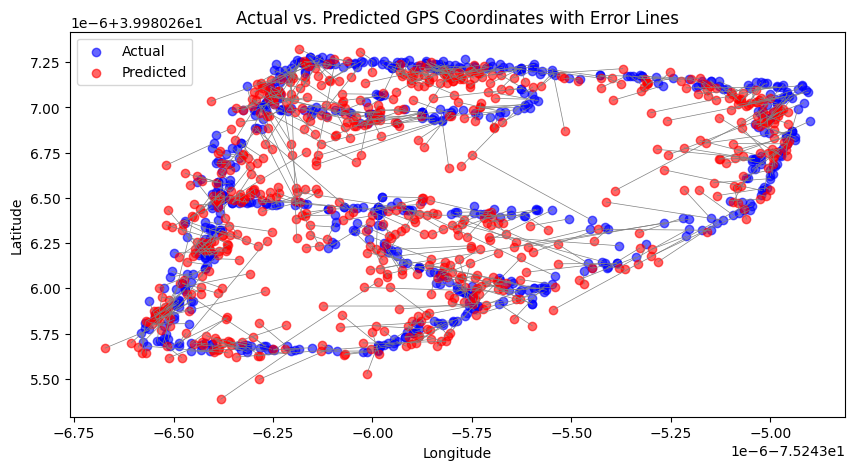

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot actual points
plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)

# Plot predicted points
plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)

# Draw lines connecting actual and predicted points
for i in range(len(all_actuals_denorm)):
    plt.plot(
        [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
        [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
        color='gray', linewidth=0.5
    )

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), f"{path}/EfficientNet_B3_state.pth")

# 8. Test on the provided dataset

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from datasets import load_dataset

In [ ]:
ds = load_dataset("gydou/5190_Spring_Final_Hidden_Data_Released")['test']

README.md:   0%|          | 0.00/356 [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/402M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
class infer_data(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds, self.transform = hf_ds, transform
    def __len__(self):
      return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = self.transform(ex["image"])
        return img, f"{idx:06d}.jpg"

test_loader = DataLoader(infer_data(ds, inference_transform),
                         batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
rows = []
with torch.no_grad():
    for imgs, fnames in test_loader:
      imgs = imgs.to(device)
      output_efficient = model(imgs)
      output_densenet = densenet(imgs)
      output_resnet = resnet(imgs)

      preds_efficient = output_efficient.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
      preds_densenet = output_densenet.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
      preds_resnet = output_resnet.cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

      preds = (preds_efficient * weights[0] + preds_densenet * weights[1] + preds_resnet * weights[2])

      for f, (lat, lon) in zip(fnames, preds):
        # change tensor to float
        lat = lat.item()
        lon = lon.item()
        rows.append({"Latitude": lat, "Longitude": lon})

In [ ]:
rows[0]

{'Latitude': 39.95128334746372, 'Longitude': -75.19195502312839}

In [ ]:
csv_out = os.path.join(path, "test_data_predictions.csv")
pd.DataFrame(rows).to_csv(csv_out, index=False)